# 对数据合并后 看懂数据结构后 列名  缺失情况 目标分布 决定清洗策略  
# 对数据的第一印象 & 清洗计划

In [2]:
from pathlib import Path
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [10]:
PARQUET_PATH = Path("../data/processed/training_oncourt.parquet")
CSV_PATH     = Path("../data/processed/training_oncourt.csv")

In [7]:
OUT_DIR = Path("reports/eda_1_raw_long")
OUT_DIR.mkdir(parents = True, exist_ok = True)

In [11]:
if PARQUET_PATH.exists():
    df = pd.read_parquet(PARQUET_PATH)
    source_used = PARQUET_PATH
elif CSV_PATH.exists():
    df = pd.read_csv(CSV_PATH)
    source_used = CSV_PATH
else:
    raise FileNotFoundError("none for both data/processed/training_oncourt.parquet and none for training_oncourt.csv")
print(f"✅ Loaded: {source_used}   shape={df.shape}")
display(df.head())

✅ Loaded: ..\data\processed\training_oncourt.parquet   shape=(2082, 33)


,Player_id,Player,Team,season,Age,GP,W,L,Min,PTS,...,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,Unnamed: 30,salary_usd
0,1,Stephen Curry,GSW,2020,33,63,37,26,34.2,32.0,...,3.4,1.2,0.1,1.9,47.9,8,0,3.9,NaN,43006362.0
1,2,Bradley Beal,WAS,2020,28,60,32,28,35.8,31.3,...,3.1,1.2,0.4,2.3,45.0,4,0,-0.1,NaN,28751775.0
2,3,Damian Lillard,POR,2020,30,67,39,28,35.8,28.8,...,3.0,0.9,0.3,1.5,45.7,16,0,3.0,NaN,31626953.0
3,4,Joel Embiid,PHI,2020,27,51,39,12,31.1,28.5,...,3.1,1.0,1.4,2.4,49.3,31,0,7.9,NaN,29542010.0
4,5,Giannis Antetokounmpo,MIL,2020,26,61,40,21,33.0,28.1,...,3.4,1.2,1.2,2.8,53.9,41,7,6.7,NaN,27528090.0


In [12]:
print("The shape is: ", df.shape)
print("\nColumn Names: ", list(df.columns))

print("\nData Type: ")
display(df.dtypes.value_counts())
display(df.dtypes)

# 常识性检查：关键列是否存在
must_have = ["Player_id", "season", "salary_usd"]
missing = [c for c in must_have if c not in df.columns]
print("\nKey Columns Check: ", "OK" if not missing else f"Missing {missing}")

The shape is:  (2082, 33)

Column Names:  ['Player_id', 'Player', 'Team', 'season', 'Age', 'GP', 'W', 'L', 'Min', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', 'TD3', '+/-', 'Unnamed: 30', 'salary_usd']

Data Type: 


float64    23
int64       8
object      2
Name: count, dtype: int64

Player_id        int64
Player          object
Team            object
season           int64
Age              int64
GP               int64
W                int64
L                int64
Min            float64
PTS            float64
FGM            float64
FGA            float64
FG%            float64
3PM            float64
3PA            float64
3P%            float64
FTM            float64
FTA            float64
FT%            float64
OREB           float64
DREB           float64
REB            float64
AST            float64
TOV            float64
STL            float64
BLK            float64
PF             float64
FP             float64
DD2              int64
TD3              int64
+/-            float64
Unnamed: 30    float64
salary_usd     float64
dtype: object


Key Columns Check:  OK


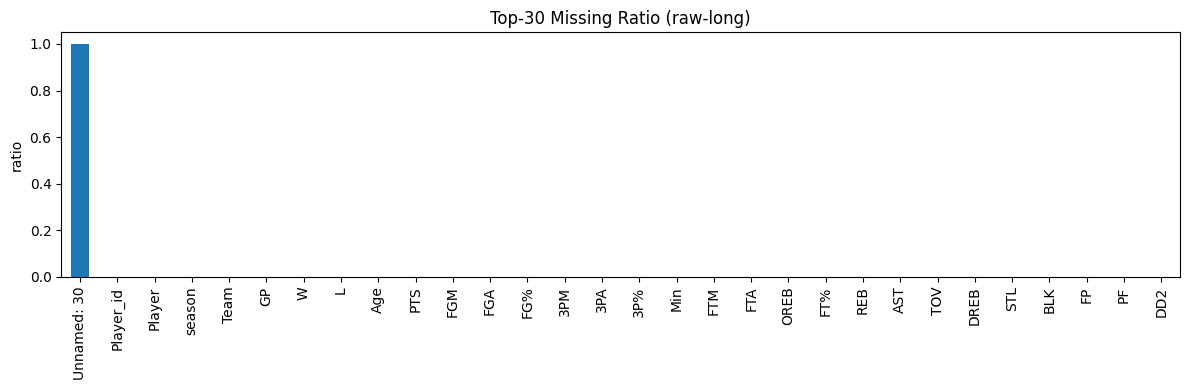

总体缺失最大比例： 1.0


Unnamed: 30    1.0
Player_id      0.0
Player         0.0
season         0.0
Team           0.0
GP             0.0
W              0.0
L              0.0
Age            0.0
PTS            0.0
FGM            0.0
FGA            0.0
FG%            0.0
3PM            0.0
3PA            0.0
3P%            0.0
Min            0.0
FTM            0.0
FTA            0.0
OREB           0.0
FT%            0.0
REB            0.0
AST            0.0
TOV            0.0
DREB           0.0
STL            0.0
BLK            0.0
FP             0.0
PF             0.0
DD2            0.0
dtype: float64

In [13]:
# === 缺失值比例 TopN，导出csv ===
na_ratio = df.isna().mean().sort_values(ascending=False)
na_ratio.to_csv(OUT_DIR / "missing_ratio_in_training_oncourt.csv")

topn = na_ratio.head(30)
ax = topn.plot(kind="bar", figsize=(12,4))
ax.set_title("Top-30 Missing Ratio (raw-long)")
ax.set_ylabel("ratio")
plt.tight_layout()
plt.show()

print("总体缺失最大比例：", float(na_ratio.max()))
display(topn)

In [14]:
all_na_cols = [c for c in df.columns if df[c].isna().all()]
const_cols = []
for c in df.columns:
    try:
        nun = df[c].nunique(dropna=True)
        if nun <= 1:
            const_cols.append(c)
    except Exception:
        pass

dup_rows = df.duplicated().sum()

print("All missing Columns: ", all_na_cols)
print("Constant (unique value ≤ 1) column: ", const_cols)
print("Duplicated Rows: ", dup_rows)

# 导出列表，方便清洗阶段引用
pd.Series(all_na_cols).to_csv(OUT_DIR / "all_na_cols_in_training_oncourt.csv", index=False, header=False)
pd.Series(const_cols).to_csv(OUT_DIR / "constant_cols_in_training_oncourt.csv", index=False, header=False)

All missing Columns:  ['Unnamed: 30']
Constant (unique value ≤ 1) column:  ['Unnamed: 30']
Duplicated Rows:  0


In [15]:
if set(["Player_id","season"]).issubset(df.columns):
    dup_keys = df.duplicated(subset=["Player_id", "season"]).sum()
    print("Set (Player_id, season) as primary key's duplicated rows: ", dup_keys)
    if dup_keys > 0:
        display(df[df.duplicated(subset=["Player_id","season"], keep=False)]
                .sort_values(["Player_id","season"])
                .head(10))
else:
    print("Missing Player_id or season columns, unable to check composite key.")

Set (Player_id, season) as primary key's duplicated rows:  0


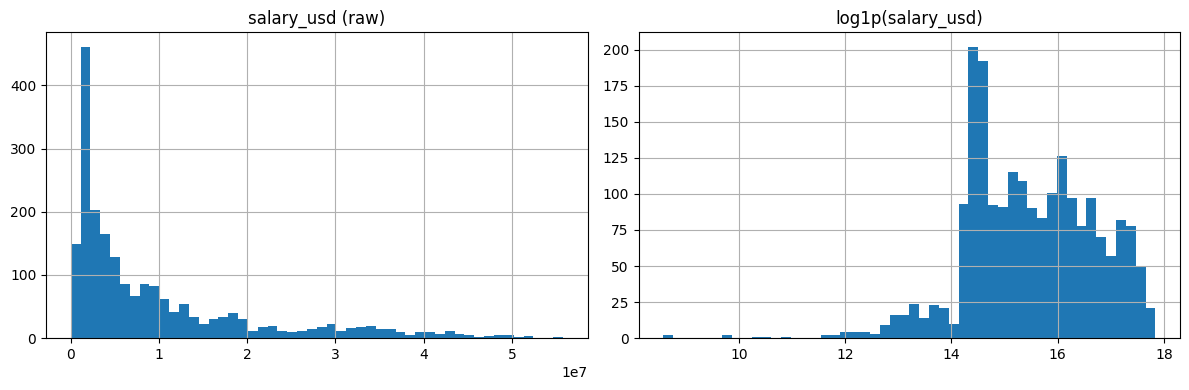

count    2.082000e+03
mean     9.794686e+06
std      1.104683e+07
min      5.318000e+03
10%      1.563518e+06
25%      2.068909e+06
50%      5.000000e+06
75%      1.296000e+07
90%      2.810354e+07
95%      3.534402e+07
99%      4.596348e+07
max      5.576122e+07
Name: salary_usd, dtype: float64

In [16]:
# === 目标变量分布（原始 & log1p） ===
import numpy as np

assert "salary_usd" in df.columns, "缺少 salary_usd 列"

fig, axes = plt.subplots(1,2, figsize=(12,4))
df["salary_usd"].dropna().hist(bins=50, ax=axes[0])
axes[0].set_title("salary_usd (raw)")

np.log1p(df["salary_usd"].clip(lower=0)).dropna().hist(bins=50, ax=axes[1])
axes[1].set_title("log1p(salary_usd)")
plt.tight_layout()
plt.show()

display(df["salary_usd"].describe(percentiles=[.1,.25,.5,.75,.9,.95,.99]))


mean 979W
std: 1104w 
min 5318 dollars(exibit 10 or two ways)
This is not normal distribution. a few very high salaries make the average higher.
10%   $1.56M     前 10% 的球员薪水低于 156 万（底薪/二年级合同）
25%   $2.07M     前 25% 的球员低于 207 万
50%   $5.00M     中位数 500 万，比均值低很多（→ 右偏分布）
75%   $12.96M    前 25% 高薪球员都在 1296 万以上
90%   $28.1M     前 10% 超级高薪球员
95%   $35.3M     顶薪球员（大部分巨星合同）
99%   $45.9M     顶级超级合同
max   $55.7M     历史顶薪（例如 Stephen Curry 2023-24）

The sample number for every season: 


season
2020    408
2021    422
2022    418
2023    411
2024    423
Name: count, dtype: int64

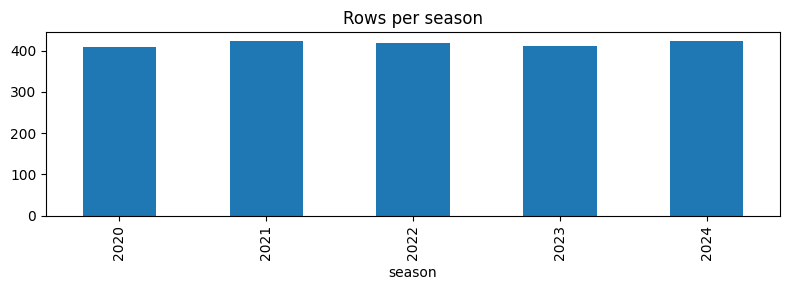

Top 15 Team Samples: 


Team
PHI    77
DET    76
TOR    74
SAS    73
BKN    72
DAL    72
OKC    72
LAC    71
MIA    71
CHA    71
MEM    71
POR    71
PHX    71
WAS    70
CHI    70
Name: count, dtype: int64

In [17]:
# === season & team 分布 ===
if "season" in df.columns:
    vc_season = df["season"].value_counts().sort_index()
    print("The sample number for every season: ")
    display(vc_season)

    ax = vc_season.plot(kind="bar", figsize=(8,3), title="Rows per season")
    plt.tight_layout(); plt.show()

if "Team" in df.columns:
    vc_team = df["Team"].value_counts()
    print("Top 15 Team Samples: ")
    display(vc_team.head(15))

Consistant Check： {'Min<=0 count': 0, 'GP<=0 count': 0}


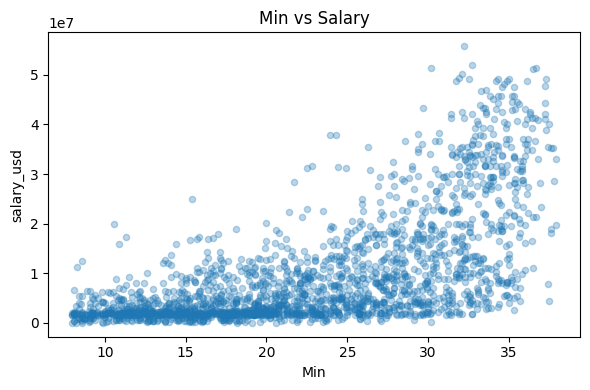

In [18]:
# === 基础一致性检查：Min 与 GP ===
issues = {}

if "Min" in df.columns:
    zero_min = (df["Min"] <= 0).sum()
    issues["Min<=0 count"] = int(zero_min)

if "GP" in df.columns:
    zero_gp = (df["GP"] <= 0).sum()
    issues["GP<=0 count"] = int(zero_gp)

print("Consistant Check：", issues)

# 可视化 Min 与 salary 的关系（粗看）
if set(["Min","salary_usd"]).issubset(df.columns):
    df.plot(kind="scatter", x="Min", y="salary_usd", alpha=0.3, figsize=(6,4), title="Min vs Salary")
    plt.tight_layout(); plt.show()


In [23]:
# === 与 salary 的线性相关（数值列） ===
num = df.select_dtypes(include="number").copy()

# 排除目标自身
num_wo_target = num.drop(columns=[c for c in ["salary_usd"] if c in num.columns], errors="ignore")

corr = num_wo_target.corrwith(num["salary_usd"]).sort_values(ascending=False)
corr_df = pd.DataFrame({"feature": corr.index, "corr_with_salary": corr.values})

# 导出完整表
corr_df.to_csv(OUT_DIR / "corr_with_salary.csv", index=False)

print("与 salary 正相关 Top 32")
display(corr_df.head(32))

print("与 salary 负相关 Top 32")
display(corr_df.tail(32))

与 salary 正相关 Top 32


,feature,corr_with_salary
0,FP,0.726206
1,PTS,0.722465
2,FGM,0.713390
3,FGA,0.692322
4,FTM,0.662823
5,FTA,0.647717
6,Min,0.641671
7,TOV,0.623317
8,AST,0.587395
9,DREB,0.524406


与 salary 负相关 Top 32


,feature,corr_with_salary
0,FP,0.726206
1,PTS,0.722465
2,FGM,0.713390
3,FGA,0.692322
4,FTM,0.662823
5,FTA,0.647717
6,Min,0.641671
7,TOV,0.623317
8,AST,0.587395
9,DREB,0.524406


In [24]:
# === 数值特征的极端值（以 |z|>3 粗略计数） ===
from scipy.stats import zscore

extreme_stats = []
for c in num_wo_target.columns:
    s = num_wo_target[c].dropna().astype(float)
    if len(s) < 50: 
        continue
    z = zscore(s)
    extreme = int((np.abs(z) > 3).sum())
    extreme_stats.append((c, extreme, int(len(s))))

extreme_df = pd.DataFrame(extreme_stats, columns=["feature", "extreme_count(|z|>3)", "non_null"])
extreme_df = extreme_df.sort_values("extreme_count(|z|>3)", ascending=False)
display(extreme_df.head(20))
extreme_df.to_csv(OUT_DIR / "extreme_value_counts_in_training_oncourt.csv", index=False)


,feature,extreme_count(|z|>3),non_null
26,DD2,66,2082
14,FTM,44,2082
17,OREB,40,2082
23,BLK,37,2082
15,FTA,36,2082
18,DREB,33,2082
19,REB,33,2082
20,AST,33,2082
10,FG%,29,2082
27,TD3,26,2082


In [26]:
# === 形成清洗TODO建议（根据上面EDA的发现，生成待办） ===
todo = []

# 1) 全空列
if len(all_na_cols) > 0:
    todo.append(f"删除全空列：{all_na_cols}")

# 2) 常数列
if len(const_cols) > 0:
    todo.append(f"删除常数列：{const_cols}")

# 3) 缺失较多的列（>50%）
high_na_cols = list(na_ratio[na_ratio > 0.5].index)
if high_na_cols:
    todo.append(f"缺失>50%的列（考虑删除或谨慎填补）：{high_na_cols}")

# 4) 主键重复
if set(["Player_id","season"]).issubset(df.columns):
    dup_keys_cnt = df.duplicated(subset=["Player_id", "season"]).sum()
    if dup_keys_cnt > 0:
        todo.append(f"(Player_id, season) 复合键有重复：{dup_keys_cnt} 行，需要去重规则")

# 5) Min/GP 问题
if "Min" in df.columns and (df["Min"] <= 0).sum() > 0:
    todo.append("Min<=0 的样本，需确认是否删除或保留（例如几乎未出场）")
if "GP" in df.columns and (df["GP"] <= 0).sum() > 0:
    todo.append("GP<=0 的样本，需确认是否删除或保留")

# 6) 目标分布强偏态 → 后续建模是否对 salary or 特征做 log1p
todo.append("目标 salary_usd 偏态较强（通常如此），后续可考虑对输入特征做 log/分桶，而目标保持原值或报告对数指标")

print("🧹 清洗/预处理 TODO 草单：")
for i, t in enumerate(todo, 1):
    print(f"{i}. {t}")

# 同步保存到文本文件，方便之后 clean_preprocess.py 参考
with open(OUT_DIR / "cleaning_todo.txt", "w", encoding="utf-8") as f:
    for t in todo:
        f.write("- " + t + "\n")
print("\n✅ 已保存：", OUT_DIR / "cleaning_todo_training_oncourt.txt")

🧹 清洗/预处理 TODO 草单：
1. 删除全空列：['Unnamed: 30']
2. 删除常数列：['Unnamed: 30']
3. 缺失>50%的列（考虑删除或谨慎填补）：['Unnamed: 30']
4. 目标 salary_usd 偏态较强（通常如此），后续可考虑对输入特征做 log/分桶，而目标保持原值或报告对数指标

✅ 已保存： reports\eda_1_raw_long\cleaning_todo_training_oncourt.txt
